In [56]:
from ngsolve import *
# from ngsolve.webgui import Draw

import netgen.gui
%gui tk

In [57]:
import numpy as np

import matplotlib.pyplot as plt

from netgen.csg import *
from ngsolve import *

In [58]:
#### Geometry
scale = 1e3  # --> computation in mm
h = 0.01*scale
b = 0.01*scale
l = 0.1*scale

## Plane means halfspace in CSG: 
## Plane(p, n) -- plane in Point p, outer normal vector n
## bc -- set boundary condition number
p_x0 =  Plane(Pnt(0,0,0),  Vec(-1,0,0)).bc("fix")
p_x1 = Plane(Pnt(l,0,0),  Vec(1,0,0)) .bc("tip")
p_z1 =   Plane(Pnt(0,0,h/2),  Vec(0,0,1)) .bc("free")
p_z0 =  Plane(Pnt(0,0,-h/2), Vec(0,0,-1)).bc("free")
p_y1 =  Plane(Pnt(0,b/2,0),  Vec(0,1,0)) .bc("free")
p_y0 = Plane(Pnt(0,-b/2,0),  Vec(0,-1,0)).bc("free")

## generate geometry from halfspaces
## consists of two hexaedra made from 6 planes
## * ... intersection 
## - ... difference
## + ... union
geometry = CSGeometry()
matnr_1 = geometry.Add(p_x0 * p_x1 * p_z1 * p_y1 * p_y0  * p_z0)
geometry.Draw()

netgenmesh = geometry.GenerateMesh(maxh=0.004*scale)
ZRefinement(netgenmesh, geometry)
mesh = Mesh(netgenmesh)
Draw(mesh)

 Calc Triangle Approximation
 Object 0 has 1292 triangles
 Start Findpoints
 Analyze spec points
 Find edges
 Start Findpoints
 Analyze spec points
 Find edges
 Start Findpoints
 Analyze spec points
 Find edges
 Surface 1 / 6
 Optimize Surface
 Surface 2 / 6
 Optimize Surface
 Surface 3 / 6
 Optimize Surface
 Surface 4 / 6
 Optimize Surface
 Surface 5 / 6
 Optimize Surface
 Surface 6 / 6
 Optimize Surface
 Delaunay meshing
 Remove Illegal Elements
 Volume Optimization


In [67]:
## Elastic modulus
Emodul = 10000  ## N/mm^2
## Poisson ratio
nu = 0.3

Hmodul = 1000

Yieldstress = 100

## Lame parameters
lam = Emodul*nu/(1-2*nu)/(1+nu)
mu = Emodul/2/(1+nu)

## external compressive force density
loadpar = Parameter(0)
direction = 0

In [68]:
Vu = VectorH1(mesh, order=1, dirichlet="fix")
Vep = L2(mesh, order=0)**5

V = Vu*Vep


In [69]:
def dev2mat(e): return CoefficientFunction((e[0], e[4], e[3], e[4], e[1], e[2], e[3], e[4], -e[0]-e[1]), dims=(3,3))

In [70]:

solution = GridFunction(V)
u = solution.components[0]
ep = solution.components[1]
epsp = dev2mat(ep)

Draw(u, mesh, "u")
Draw(BoundaryFromVolumeCF(epsp), mesh, "epsp")
strain = 0.5*(Grad(u)+Grad(u).trans)
stress = 2*mu*(strain-epsp) + lam*Trace(strain)*Id(3)
Draw(BoundaryFromVolumeCF(strain), mesh, "eps")
Draw(BoundaryFromVolumeCF(stress), mesh, "sigma")
mises = 1./np.sqrt(2)*sqrt( (stress[0]-stress[4])**2 + (stress[4]-stress[8])**2 + (stress[8]-stress[0])**2 + 6*(stress[1]**2 + stress[2]**2 + stress[5]**2) )
Draw(BoundaryFromVolumeCF(mises), mesh, "mises")

solution_old = GridFunction(V)
u_old = solution_old.components[0]
ep_old = solution_old.components[1]
epsp_old = dev2mat(ep_old)



In [71]:
U, EP = V.TrialFunction()
DELTAU, DELTAEP = V.TestFunction()

EPSP = dev2mat(EP)
DELTAEPSP = dev2mat(DELTAEP)

EPS = 0.5*(Grad(U)+Grad(U).trans)
DELTAEPS = 0.5*(Grad(DELTAU)+Grad(DELTAU).trans)

In [72]:
def ElasticWork(EPSE, DELTAEPSE):
    return 2*mu*InnerProduct(EPSE, DELTAEPSE) + lam*Trace(EPSE)*Trace(DELTAEPSE)

def HardeningWork(EPSP, DELTAEPSP):
    return 2./3.*Hmodul*InnerProduct(EPSP, DELTAEPSP)

def Dissipation(dotEPSP, alphareg):
    return np.sqrt(2./3.)*Yieldstress * sqrt(InnerProduct(dotEPSP,dotEPSP)+alphareg**2)

In [73]:
a = BilinearForm(V)
a += SymbolicBFI(ElasticWork(EPS-EPSP, DELTAEPS-DELTAEPSP).Compile())
a += SymbolicBFI(HardeningWork(EPSP, DELTAEPSP).Compile())
a += SymbolicEnergy(Dissipation(EPSP - epsp_old, alphareg = 1e-6).Compile())

a += SymbolicBFI(-loadpar*DELTAU[direction], definedon=mesh.Boundaries("tip"))


In [74]:
if direction == 0: loadsteps = np.concatenate((np.linspace(0,100,5,endpoint=False), np.linspace(100,102,6)) )
if direction == 1: loadsteps = np.linspace(0,3,11,endpoint=True)

solution_old.vec[:] = 0
solution.vec[:] = 0

forcelist = []
displist = []

for load in loadsteps[1:]:
    print("load ", load)
    loadpar.Set(load)

    err, nit = solvers.Newton(a, solution, maxit=50, maxerr=1e-8, printing=False)

    if not err:
        solution_old.vec.data = solution.vec
        forcelist.append(load)
        displist.append(u(mesh(l,0,0))[direction])
        print(f"u = {displist[-1]}, newton its {nit}")
    else:
        print("newton did not converge")
        break

    

    

load  20.0
u = 0.19883711906843565, newton its 4
load  40.0
u = 0.3976928830013775, newton its 5
load  60.0


Text(0, 0.5, 'force density $f$/N$\\,$mm$^{-2}$')

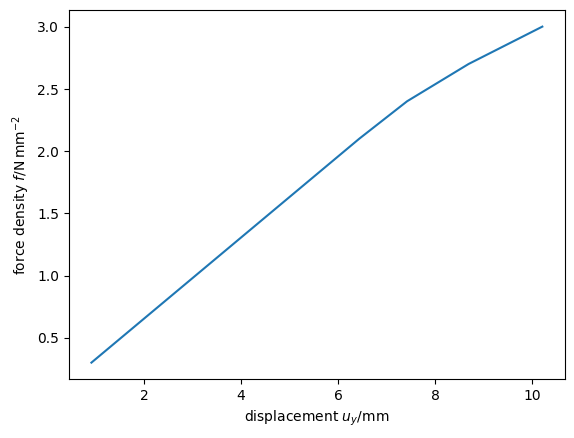

In [ ]:
plt.plot(displist, forcelist)
if direction == 0: plt.plot([displist[0], displist[-1]], [Yieldstress,Yieldstress], ":")
if direction == 0: plt.xlabel(r"displacement $u_x$/mm")
if direction == 1: plt.xlabel(r"displacement $u_y$/mm")
plt.ylabel(r"force density $f$/N$\,$mm$^{-2}$")